### Merging datasets (ML paradigm + PLC phase + ML method)

- **ML category**  
  ML paradigm classification using SciBERT predictions  
  *(source: `scibert_tuned`)*

- **PLC phase**  
  Semantic PLC classification  
  *(source: `semantic_analysis_ext_desc`)*

- **ML method**  
  Machine learning methods extracted from abstracts using regex-based matching  
  *(source: `regex_scispacy`)*

Datasets are merged on **DOI**.  
This means that abstracts (DOIs) without data in any of the datasets are not included.


In [1]:
# Imports

import pandas as pd
from pathlib import Path
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Paths

processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "total_results"

ml_methods_path = processed_abstracts_path / "regex_scispacy/abstracts_with_ml_methods_regex.csv"
ml_category_path = processed_abstracts_path / "scibert_tuned/abstracts_with_predictions.csv"
production_category_path = processed_abstracts_path / "semantic_analysis_ext_desc/abstracts_min_phases.csv"
prod_cluster_keywords_path = processed_abstracts_path / "semantic_analysis_ext_desc/keywords.json"
figures_path = Path("../../reports/figures/plc_scibert_analysis")
table_path = Path("../../reports/tables/plc_scibert_analysis")

# Ensure directories exist
for p in [processed_abstracts_path, save_path, figures_path, table_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load Data

# ML-methods
df_ml_methods = pd.read_csv(ml_methods_path)

# ML-category
df_ml_category = pd.read_csv(ml_category_path)

# Production category
df_prod_category = pd.read_csv(production_category_path)

# Production cluster keywords
with open(prod_cluster_keywords_path, "r", encoding="utf-8") as f:
    prod_cluster_keywords = json.load(f)

In [4]:
# Check columns
print(df_ml_methods.columns)
print(df_ml_category.columns)
print(df_prod_category.columns)

Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'ml_methods_regex', 'method_count'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'is_supervised', 'is_unsupervised', 'is_reinforcement',
       'pred_is_supervised', 'pred_is_unsupervised', 'pred_is_reinforcement'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs', 'phase',
       'phase_max_prob', 'phase_margin', 'token_count', 'over_max_len'],
      dtype='object')


In [5]:
# Check head of each dataset
df_ml_methods.head(2)

,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count
0,ml_end_of_life,2-s2.0-105008951371,10.3390/su17125511,Review and Novel Framework with Hui–Walter Met...,© 2025 by the authors.Consumers’ growing inter...,Consumers’ growing interest in sustainability ...,[],0
1,ml_end_of_life,2-s2.0-85174142475,10.3390/asi6050076,Measuring Carbon in Cities and Their Buildings...,© 2023 by the authors.According to the Europea...,"According to the European Green Deal, excessiv...",['Linear Regression'],1


In [6]:
df_ml_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,0,0,1
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,0,0,0


In [7]:
df_prod_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,phase,phase_max_prob,phase_margin,token_count,over_max_len
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,4,0.265862,0.010928,217,False
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",4,0.279328,0.027828,303,False


In [8]:
df_ml_category.info()
print()
df_ml_methods.info()
print()
df_prod_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   query_id               33130 non-null  object
 1   eid                    33130 non-null  object
 2   doi                    33129 non-null  object
 3   title                  33130 non-null  object
 4   abstract               33130 non-null  object
 5   clean_abs              33129 non-null  object
 6   is_supervised          33130 non-null  bool  
 7   is_unsupervised        33130 non-null  bool  
 8   is_reinforcement       33130 non-null  bool  
 9   pred_is_supervised     33130 non-null  int64 
 10  pred_is_unsupervised   33130 non-null  int64 
 11  pred_is_reinforcement  33130 non-null  int64 
dtypes: bool(3), int64(3), object(6)
memory usage: 2.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 8 columns):
 #   Colu

In [9]:
# Config

ID_COL = "doi"
RAW_ML_METHOD_COL = "ml_methods_regex"
ML_METHOD_COL = "ml_method"
ML_CAT_COL = "ml_category"
RAW_PROD_CAT_COL = "phase"
PROD_CAT_COL = "phase"



In [10]:
# Build ML categories per axis

ml_pred_cols = ["pred_is_supervised", "pred_is_unsupervised", "pred_is_reinforcement"]

ml_long = (
    df_ml_category[[ID_COL] + ml_pred_cols]
    .melt(id_vars=ID_COL, var_name="ml_axis", value_name="is_active")
)

ml_long = ml_long[ml_long["is_active"] == 1].copy()

ml_long[ML_CAT_COL] = ml_long["ml_axis"].map({
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement",
})

ml_long = ml_long[[ID_COL, ML_CAT_COL]]

print("Number of unique DOIs with ML categories:", ml_long[ID_COL].nunique())
print("Total ml category rows:", len(ml_long))

print("ML category counts:")
ml_long[ML_CAT_COL].value_counts()


Number of unique DOIs with ML categories: 29836
Total ml category rows: 32240
ML category counts:


ml_category
supervised       23309
reinforcement     4557
unsupervised      4374
Name: count, dtype: int64

In [11]:
# Parse ML method list column

def parse_method_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if not s or s == "[]":
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except (ValueError, SyntaxError):
        return [s]

df_ml_methods["ml_methods_list"] = df_ml_methods[RAW_ML_METHOD_COL].apply(parse_method_list)
df_ml_methods[[RAW_ML_METHOD_COL, "ml_methods_list"]].head(5)


,ml_methods_regex,ml_methods_list
0,[],[]
1,['Linear Regression'],[Linear Regression]
2,"['Linear Regression', 'Support Vector Regressi...","[Linear Regression, Support Vector Regression,..."
3,['Neural Network'],[Neural Network]
4,[],[]


In [12]:
# Explode methods to one row per doi–method

df_methods_long = (
    df_ml_methods[[ID_COL, "ml_methods_list"]]
    .explode("ml_methods_list")
    .rename(columns={"ml_methods_list": ML_METHOD_COL})
)

df_methods_long = df_methods_long[
    df_methods_long[ML_METHOD_COL].notna()
    & (df_methods_long[ML_METHOD_COL].astype(str).str.strip() != "")
]

df_methods_long.head()


,doi,ml_method
1,10.3390/asi6050076,Linear Regression
2,10.1016/j.resconrec.2023.107073,Linear Regression
2,10.1016/j.resconrec.2023.107073,Support Vector Regression
2,10.1016/j.resconrec.2023.107073,Gradient Boosting
3,10.1016/j.dche.2023.100103,Neural Network


In [13]:
# Production categories

df_prod_long = (
    df_prod_category[[ID_COL, RAW_PROD_CAT_COL]]
    .rename(columns={RAW_PROD_CAT_COL: PROD_CAT_COL})
)

df_prod_long.head()


,doi,phase
0,10.1016/B978-0-443-33740-6.00012-8,4
1,10.1080/19397038.2025.2563271,4
2,10.1109/TEMSCON-ASPAC62480.2024.11025082,4
3,10.1188/23.CJON.595-601,1
4,10.1039/d3va00106g,4


In [14]:
# Full long table: one row per doi–method–ml_category–prod_category

df_all = (
    df_methods_long[[ID_COL, ML_METHOD_COL]]
    .merge(ml_long, on=ID_COL, how="inner")
    .merge(df_prod_long, on=ID_COL, how="inner")
)

print(df_all.shape)
df_all.head()


(35689, 4)


,doi,ml_method,ml_category,phase
0,10.3390/asi6050076,Linear Regression,supervised,1
1,10.1016/j.resconrec.2023.107073,Linear Regression,supervised,4
2,10.1016/j.resconrec.2023.107073,Support Vector Regression,supervised,4
3,10.1016/j.resconrec.2023.107073,Gradient Boosting,supervised,4
4,10.1016/j.dche.2023.100103,Neural Network,supervised,4


In [15]:
# Quick sanity check and neural network count

print("ML categories:")
print(df_all[ML_CAT_COL].value_counts())

print("\nProduction categories:")
print(df_all[PROD_CAT_COL].value_counts())

print("\nExample methods:")
print(df_all[ML_METHOD_COL].value_counts().head(20))


ML categories:
ml_category
supervised       28271
unsupervised      5279
reinforcement     2139
Name: count, dtype: int64

Production categories:
phase
3    19750
4     7158
2     6371
1     2410
Name: count, dtype: int64

Example methods:
ml_method
Neural Network                  6968
Random Forest                   3446
Support Vector Machine          2543
Decision Tree                   1755
Convolutional Neural Network    1457
Gradient Boosting               1287
XGBoost                         1208
LSTM                            1200
Linear Regression                993
Principal Component Analysis     948
K-Nearest Neighbors              941
Bayesian Method                  930
Genetic Algorithm                876
Support Vector Regression        783
Particle Swarm Optimization      644
Autoencoder                      546
Logistic Regression              545
K-Means                          536
Deep Neural Network              504
SHAP                             492
Name: coun

In [ ]:
# Save dataset 

# df_all.to_csv(save_path / "plc_scibert.csv")

In [3]:
# Load dataset

df_all = pd.read_csv(save_path / "plc_scibert.csv")

In [17]:
# Counts per (ML category, production category, method)

group_cols = [ML_CAT_COL, PROD_CAT_COL, ML_METHOD_COL]

method_counts = (
    df_all
    .groupby(group_cols)[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
)

method_counts.head()


,ml_category,phase,ml_method,n_articles
0,reinforcement,1,ARIMA,1
1,reinforcement,1,Actor-Critic,3
2,reinforcement,1,Ant Colony Optimization,2
3,reinforcement,1,Attention Mechanism,1
4,reinforcement,1,Autoencoder,3


In [18]:
# Total unique articles per (ML category, production category)

cell_totals = (
    df_all
    .groupby([ML_CAT_COL, PROD_CAT_COL])[ID_COL]
    .nunique()
    .reset_index(name="cell_total")
)

cell_totals.head()


,ml_category,phase,cell_total
0,reinforcement,1,204
1,reinforcement,2,442
2,reinforcement,3,493
3,reinforcement,4,178
4,supervised,1,934


In [19]:
# Order categories by frequency of unique articles

ml_cat_order = (
    df_all
    .groupby(ML_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

prod_cat_order = (
    df_all
    .groupby(PROD_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

ml_cat_order, prod_cat_order


(['supervised', 'unsupervised', 'reinforcement'], [3, 2, 4, 1])

In [20]:
# Top-k methods per cell

TOP_K = 3

method_counts["rank_in_cell"] = (
    method_counts
    .groupby([ML_CAT_COL, PROD_CAT_COL])["n_articles"]
    .rank(method="dense", ascending=False)
)

top_methods = (
    method_counts[method_counts["rank_in_cell"] <= TOP_K]
    .merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL], how="left")
    .sort_values([ML_CAT_COL, PROD_CAT_COL, "n_articles"], ascending=[True, True, False])
)

top_methods.head(10)


,ml_category,phase,ml_method,n_articles,rank_in_cell,cell_total
2,reinforcement,1,Neural Network,79,1.0,204
1,reinforcement,1,Deep Reinforcement Learning,33,2.0,204
0,reinforcement,1,Bayesian Method,29,3.0,204
4,reinforcement,2,Neural Network,151,1.0,442
3,reinforcement,2,Deep Reinforcement Learning,94,2.0,442
5,reinforcement,2,Q-Learning,48,3.0,442
7,reinforcement,3,Neural Network,177,1.0,493
6,reinforcement,3,Decision Tree,54,2.0,493
8,reinforcement,3,Q-Learning,51,3.0,493
11,reinforcement,4,Neural Network,55,1.0,178


In [21]:
# Build 2D map summary

def summarize_cell(group):
    total = int(group["cell_total"].iloc[0])
    methods_str = ", ".join(
        f"{m} ({int(n)})"
        for m, n in zip(group[ML_METHOD_COL], group["n_articles"])
    )
    return pd.Series({"summary": f"n={total}; top: {methods_str}"})

cell_summary = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_cell)
    .reset_index()
)

cell_summary.head()


/tmp/ipykernel_2909511/602492248.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_cell)


,ml_category,phase,summary
0,reinforcement,1,"n=204; top: Neural Network (79), Deep Reinforc..."
1,reinforcement,2,"n=442; top: Neural Network (151), Deep Reinfor..."
2,reinforcement,3,"n=493; top: Neural Network (177), Decision Tre..."
3,reinforcement,4,"n=178; top: Neural Network (55), Deep Reinforc..."
4,supervised,1,"n=934; top: Neural Network (386), Random Fores..."


In [22]:
# Pivot to 2D grid

summary_grid = cell_summary.pivot(
    index=ML_CAT_COL,
    columns=PROD_CAT_COL,
    values="summary"
)

summary_grid = summary_grid.reindex(index=ml_cat_order, columns=prod_cat_order)

summary_grid


phase,3,2,4,1
ml_category,,,,
supervised,"n=6903; top: Neural Network (2653), Random For...","n=2719; top: Neural Network (1545), Random For...","n=2494; top: Neural Network (1167), Random For...","n=934; top: Neural Network (386), Random Fores..."
unsupervised,"n=1603; top: Neural Network (451), Principal C...","n=336; top: Neural Network (125), Autoencoder ...","n=428; top: Neural Network (147), Principal Co...","n=134; top: Neural Network (32), K-Means (29),..."
reinforcement,"n=493; top: Neural Network (177), Decision Tre...","n=442; top: Neural Network (151), Deep Reinfor...","n=178; top: Neural Network (55), Deep Reinforc...","n=204; top: Neural Network (79), Deep Reinforc..."


In [23]:
# Manual mapping: production phases to short labels (with phase number)
prod_cluster_label_map = {
    1: "1 - planning",
    2: "2 - production",
    3: "3 - optimization",
    4: "4 - re-use"
}

# Map each phase value to its label, fallback to the phase value if unknown
df_all["phase_label"] = df_all["phase"].map(prod_cluster_label_map).fillna(df_all["phase"].astype(str))

prod_cluster_label_map


{1: '1 - planning',
 2: '2 - production',
 3: '3 - optimization',
 4: '4 - re-use'}

In [24]:
bubble_df = cell_summary.merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL])

bubble_df["prod_cluster_label"] = bubble_df[PROD_CAT_COL].map(prod_cluster_label_map)

fig = px.scatter(
    bubble_df,
    x="prod_cluster_label",
    y=ML_CAT_COL,
    size="cell_total",
    # text="summary",
    size_max=100
)

fig.update_traces(textposition="top center")
# fig.update_layout(
#     width=1800,  
#     height=600   
# )
fig.show()


In [25]:
# Label map from cluster id to short description
def make_cluster_label(cid):
    cid_str = str(cid)
    words = prod_cluster_keywords.get(cid_str, [])[:4]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

prod_label_map = {cid: make_cluster_label(cid) for cid in prod_cat_order}
prod_label_to_id = {v: k for k, v in prod_label_map.items()}

# Numeric grid for heatmap
numeric_grid = (
    cell_totals
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="cell_total")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)


In [26]:
# Widgets

ml_cat_dropdown = widgets.Dropdown(
    options=ml_cat_order,
    description="ML cat",
    layout=widgets.Layout(width="300px")
)

prod_dropdown = widgets.Dropdown(
    options=[prod_label_map[c] for c in prod_cat_order],
    description="Prod",
    layout=widgets.Layout(width="400px")
)


In [27]:
# Callback for dashboard

def update_dashboard(ml_cat, prod_label, top_k=15):
    prod_id = prod_label_to_id[prod_label]
    
    subset = (
        method_counts
        .query(f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id")
        .sort_values("n_articles", ascending=False)
    )
    
    if subset.empty:
        print(f"No articles for cell: {ml_cat} × {prod_label}")
        return
    
    cell_n = int(
        cell_totals.query(
            f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id"
        )["cell_total"].iloc[0]
    )
    
    print(f"Cell: {ml_cat} × {prod_label}")
    print(f"Unique articles in cell: {cell_n}")
    print("\nTop methods:")
    
    display(subset[[ML_METHOD_COL, "n_articles"]].head(top_k))
    
    top_plot = subset.head(top_k)
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_plot[ML_METHOD_COL].astype(str), top_plot["n_articles"])
    plt.gca().invert_yaxis()
    plt.xlabel("Number of articles")
    plt.title("Top methods in selected cell")
    plt.tight_layout()
    plt.show()


In [28]:
# Bind widgets to callback

ui = widgets.VBox([ml_cat_dropdown, prod_dropdown])

out = widgets.interactive_output(
    update_dashboard,
    {"ml_cat": ml_cat_dropdown, "prod_label": prod_dropdown}
)

display(ui, out)


Output()

In [29]:
# ML category flags per article
ml_flag_cols = ["pred_is_supervised", "pred_is_unsupervised", "pred_is_reinforcement"]

df_ml_flags = df_ml_category[[ID_COL] + ml_flag_cols].copy()

# Count active categories
df_ml_flags["n_active"] = df_ml_flags[ml_flag_cols].sum(axis=1)

# Remove "none" (articles with zero ML categories)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] > 0].copy()

# Multi-label flags
df_ml_flags["is_multi"] = df_ml_flags["n_active"] > 1
df_ml_flags["multi_type"] = df_ml_flags["n_active"].map({
    1: "single",
    2: "double",
    3: "triple"
})

df_ml_flags["multi_type"].value_counts()


multi_type
single    27527
double     2217
triple       93
Name: count, dtype: int64

In [30]:
# Join ML flags with production cluster
ml_prod_flags = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

# Compute share per cluster
share_multi_by_prod = (
    ml_prod_flags
    .groupby(PROD_CAT_COL)["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

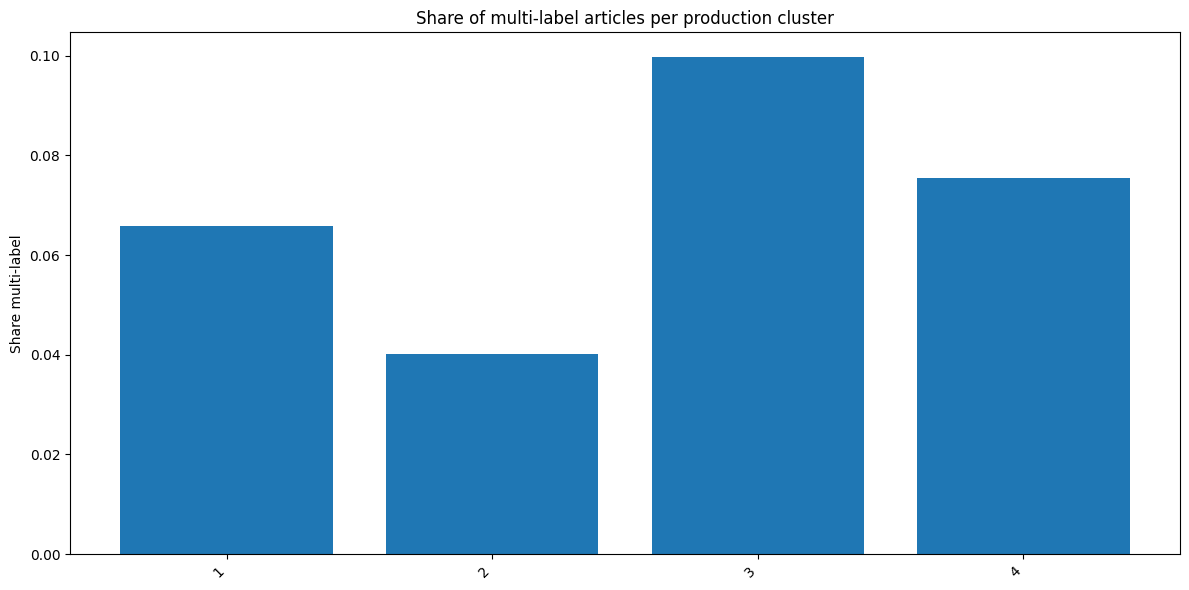

In [31]:
plot_df = share_multi_by_prod.copy()
plot_df["prod_label"] = plot_df[PROD_CAT_COL].map(prod_label_map)

plt.figure(figsize=(12, 6))
plt.bar(plot_df["prod_label"], plot_df["share_multi"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share multi-label")
plt.title("Share of multi-label articles per production cluster")
plt.tight_layout()
plt.show()


In [32]:
ml_axis_long = df_ml_flags.melt(
    id_vars=[ID_COL, "is_multi"],
    value_vars=ml_flag_cols,
    var_name="ml_axis",
    value_name="is_active"
)

ml_axis_long = ml_axis_long[ml_axis_long["is_active"] == 1].copy()

ml_axis_long["ml_axis"] = ml_axis_long["ml_axis"].map({
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement"
})

share_multi_by_axis = (
    ml_axis_long
    .groupby("ml_axis")["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

share_multi_by_axis


,ml_axis,share_multi
0,reinforcement,0.127277
1,supervised,0.095328
2,unsupervised,0.436900


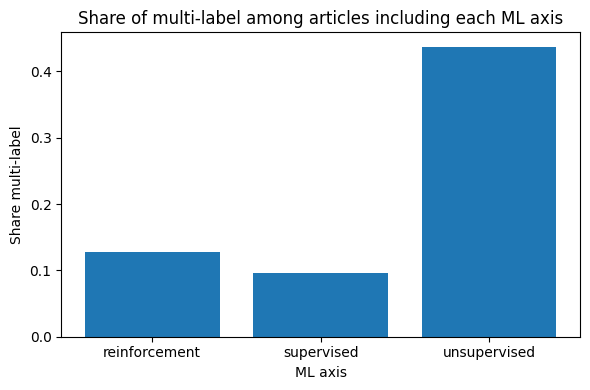

In [33]:
# Bar plot: share of multi-label among articles that include each axis

plt.figure(figsize=(6, 4))
plt.bar(share_multi_by_axis["ml_axis"], share_multi_by_axis["share_multi"])
plt.ylabel("Share multi-label")
plt.xlabel("ML axis")
plt.title("Share of multi-label among articles including each ML axis")
plt.tight_layout()
plt.show()


In [34]:
# Keep only multi-label (>=2)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] >= 2].copy()

def make_combo(row):
    parts = []
    if row["pred_is_supervised"] == 1:
        parts.append("supervised")
    if row["pred_is_unsupervised"] == 1:
        parts.append("unsupervised")
    if row["pred_is_reinforcement"] == 1:
        parts.append("reinforcement")
    return "+".join(parts)

df_ml_flags["ml_combo"] = df_ml_flags.apply(make_combo, axis=1)


df_combo_prod = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

combo_by_prod = (
    df_combo_prod
    .groupby([PROD_CAT_COL, "ml_combo"])[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
    .sort_values(["phase", "n_articles"], ascending=[True, False])
)

top3_combo_prod = (
    combo_by_prod
    .sort_values("n_articles", ascending=False)
    .head(3)
)

top3_combo_prod



,phase,ml_combo,n_articles
9,3,supervised+unsupervised,1171
13,4,supervised+unsupervised,305
5,2,supervised+unsupervised,185


In [35]:
df_ml_flags_all = df_ml_category[[ID_COL] + ml_flag_cols].copy()
df_ml_flags_all["n_active"] = df_ml_flags_all[ml_flag_cols].sum(axis=1)

# Separate none vs labeled
none_df = df_ml_flags_all[df_ml_flags_all["n_active"] == 0].copy()
labeled_df = df_ml_flags_all[df_ml_flags_all["n_active"] > 0].copy()

print("Total none:", len(none_df))
print("Total labeled:", len(labeled_df))


Total none: 3293
Total labeled: 29837


In [36]:
# Count how many total articles per production cluster
total_per_cluster = (
    df_prod_long[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("total_cluster")
)

# Count none-articles per cluster
none_prod = none_df.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

none_per_cluster = (
    none_prod[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("none_count")
)

# Combine counts
none_stats = (
    pd.concat([none_per_cluster, total_per_cluster], axis=1)
    .fillna(0)
)

# Compute share
none_stats["none_share"] = none_stats["none_count"] / none_stats["total_cluster"]

# Add readable labels (3 keywords per cluster)
def make_cluster_label(cid):
    words = prod_cluster_keywords.get(str(cid), [])[:3]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

none_stats["cluster_label"] = [
    make_cluster_label(cid) for cid in none_stats.index
]

# Reorder columns
none_stats = none_stats[
    ["cluster_label", "none_count", "total_cluster", "none_share"]
]

none_stats


,cluster_label,none_count,total_cluster,none_share
phase,,,,
1,1,263,2756,0.095428
2,2,1348,8874,0.151904
3,3,1073,15466,0.069378
4,4,609,6034,0.100928


In [37]:
# Prepare method lists
df_methods = df_ml_methods[[ID_COL, "ml_methods_list"]].copy()
df_methods["n_methods"] = df_methods["ml_methods_list"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Merge into none vs labeled
none_methods = none_df.merge(df_methods, on=ID_COL, how="left")
labeled_methods = labeled_df.merge(df_methods, on=ID_COL, how="left")

print("Avg methods (none):", none_methods["n_methods"].mean())
print("Avg methods (labeled):", labeled_methods["n_methods"].mean())

print("\nMedian methods (none):", none_methods["n_methods"].median())
print("Median methods (labeled):", labeled_methods["n_methods"].median())

# Share with zero methods
none_zero_share = (none_methods["n_methods"] == 0).mean()
labeled_zero_share = (labeled_methods["n_methods"] == 0).mean()

print("\nShare with zero methods (none):", none_zero_share)
print("Share with zero methods (labeled):", labeled_zero_share)


Avg methods (none): 0.15517764955967203
Avg methods (labeled): 1.0611321513556993

Median methods (none): 0.0
Median methods (labeled): 1.0

Share with zero methods (none): 0.8724567263893107
Share with zero methods (labeled): 0.48952642691959647
